In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('/kaggle/input/titanic/titanic.csv', index_col='PassengerId')
df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


# Exploratory Data Analysis (EDA)

Basic EDA yaitu:
- Kondisi `Target`
- Hubungan `data Numeric vs Target`
- Hubungan `data Categoric (Termasuk Numeric Ordinal) vs Target`

### Target

In [160]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

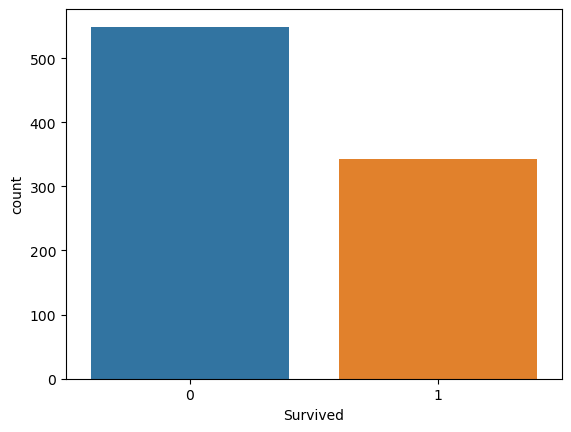

In [161]:
sns.countplot(data=df, x='Survived')

### Numeric vs Target

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x600 with 0 Axes>

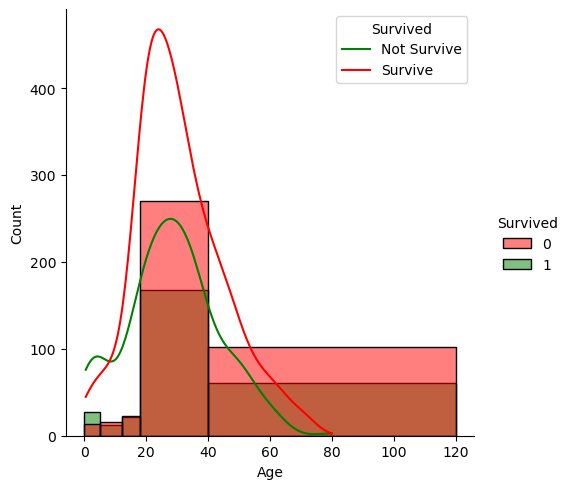

In [162]:
plt.figure(figsize=(7, 6))
sns.displot(data=df, x='Age', hue='Survived', bins=[0, 5, 12, 18, 40, 120], kde=True, palette=['r', 'g'], legend=True)

plt.legend(title='Survived', labels=['Not Survive', 'Survive'])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x600 with 0 Axes>

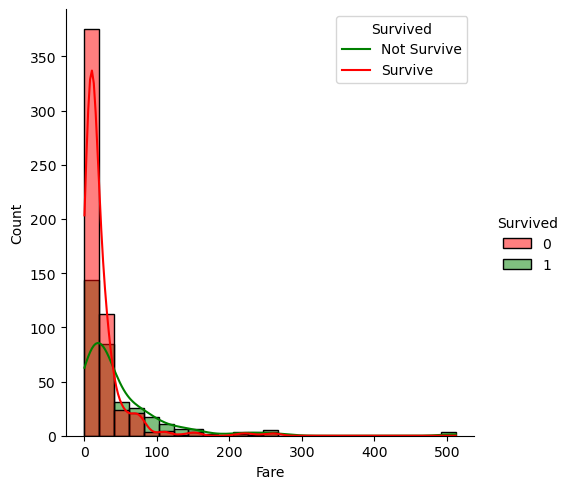

In [163]:
plt.figure(figsize=(7, 6))
sns.displot(data=df, x='Fare', hue='Survived', bins=25, kde=True, palette=['r', 'g'], legend=True)

plt.legend(title='Survived', labels=['Not Survive', 'Survive'])
plt.show()

### Categoric / Ordinal vs Target

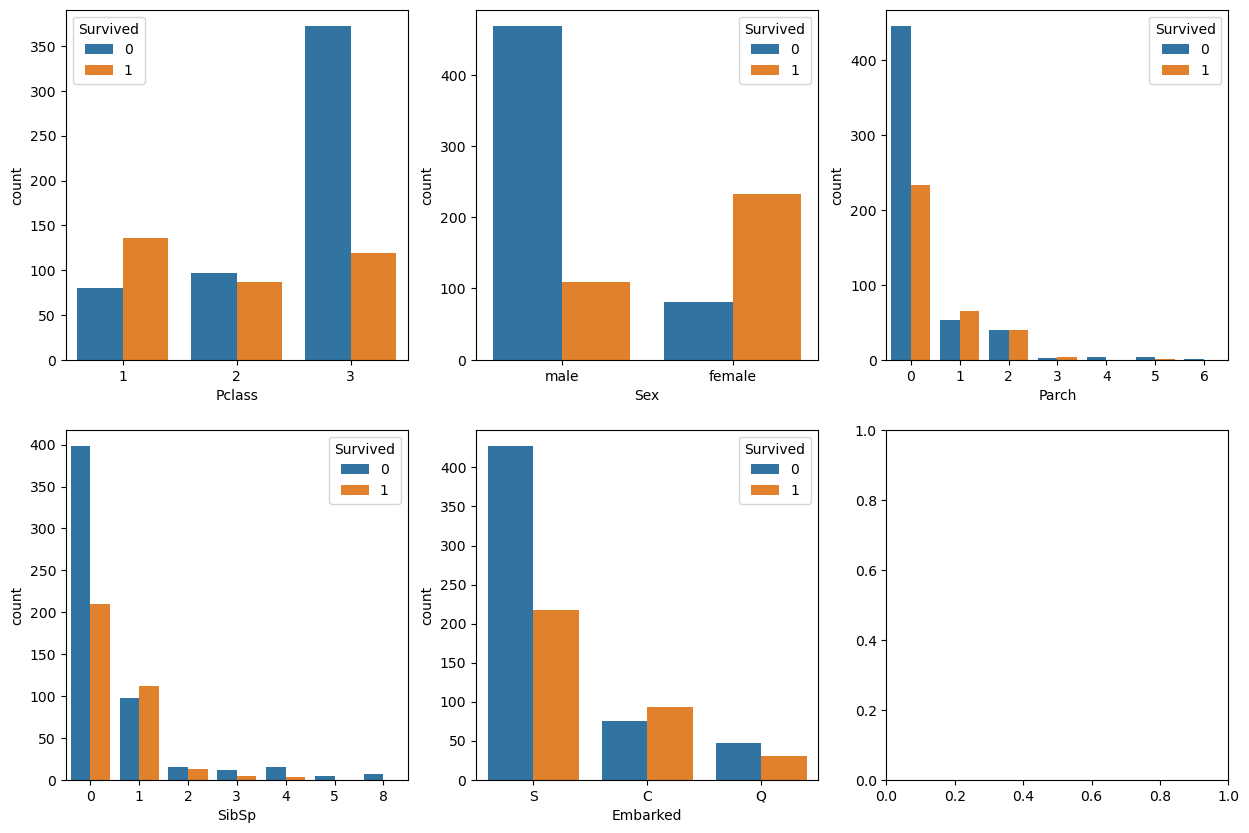

In [164]:
cat_col = ['Pclass', 'Sex', 'Parch', 'SibSp', 'Embarked']

fig, axes = plt.subplots(2, 3, figsize=(15,10))
for cat, ax in zip(cat_col, axes.flatten()):
    sns.countplot(x=cat, data=df, hue='Survived', ax=ax)

## Pandas Crostab (Optional)

In [165]:
pd.crosstab(df.Pclass, df.Survived)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [166]:
pd.crosstab(df.Pclass, df.Survived, normalize='index')

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


# Feature Engineering

### Adding Feature => isAlone

In [167]:
df['isAlone'] = (df.SibSp == 0) & (df.Parch == 0)
df.isAlone = df.isAlone.map({True: 'Ya', False: 'Tidak'})
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Tidak
2,1,1,female,38.0,1,0,71.2833,C,Tidak
3,1,3,female,26.0,0,0,7.9250,S,Ya
4,1,1,female,35.0,1,0,53.1000,S,Tidak
5,0,3,male,35.0,0,0,8.0500,S,Ya


### Binning

#### Age

In [168]:
df.Age = pd.cut(df.Age, [0, 5, 12, 18, 40, 120], labels=['balita', 'anak-anak', 'remaja', 'dewasa', 'lansia'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,7.2500,S,Tidak
2,1,1,female,dewasa,1,0,71.2833,C,Tidak
3,1,3,female,dewasa,0,0,7.9250,S,Ya
4,1,1,female,dewasa,1,0,53.1000,S,Tidak
5,0,3,male,dewasa,0,0,8.0500,S,Ya


#### Fare

In [169]:
df.Fare = pd.cut(df.Fare, [0, 25, 100, 600], labels=['murah', 'mahal', 'eksekutif'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isAlone
PassengerId,,,,,,,,,
1,0,3,male,dewasa,1,0,murah,S,Tidak
2,1,1,female,dewasa,1,0,mahal,C,Tidak
3,1,3,female,dewasa,0,0,murah,S,Ya
4,1,1,female,dewasa,1,0,mahal,S,Tidak
5,0,3,male,dewasa,0,0,murah,S,Ya


# Splitting Dataset

In [170]:
X = df.drop(columns='Survived')
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 8), (712,), (179, 8), (179,))

# Preprocessor and Pipeline using JcopML

In [171]:
!pip install jcopml

In [172]:
from jcopml.pipeline import num_pipe, cat_pipe

In [173]:
from sklearn.compose import make_column_selector as selector

In [186]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), ['SibSp', 'Parch']),
    ('categoric', cat_pipe(encoder='onehot'), ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'isAlone'])
])

preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['SibSp', 'Parch']),
                                ('categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked',
                                  'isAlone'])])

In [187]:
from jcopml.tuning import grid_search_params as gsp

In [188]:
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': [1, 1.5, 2]}

In [189]:
# Pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', KNeighborsClassifier())
])

# Parameter Tunning
model = GridSearchCV(knn_pipeline, gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['SibSp',
                                                                          'Parch']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Age',
                                                                          'Fare',
                                                                          'Embarked',
                                                                          'isAlone'])])),
                                       ('algo', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                         'algo__p': [1, 1.5, 2],
                         'algo__weights': ['uniform', 'distance']},
             verbose=1)

In [190]:
# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__n_neighbors': 7, 'algo__p': 2, 'algo__weights': 'uniform'}
0.8370786516853933 0.8160302095521752 0.7597765363128491
